# Transfer Learning Template

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

    
import os, json, sys, time, random
import numpy as np
import torch
from torch.optim import Adam
from  easydict import EasyDict
import matplotlib.pyplot as plt

from steves_models.steves_ptn import Steves_Prototypical_Network

from steves_utils.lazy_iterable_wrapper import Lazy_Iterable_Wrapper
from steves_utils.iterable_aggregator import Iterable_Aggregator
from steves_utils.ptn_train_eval_test_jig import  PTN_Train_Eval_Test_Jig
from steves_utils.torch_sequential_builder import build_sequential
from steves_utils.torch_utils import get_dataset_metrics, ptn_confusion_by_domain_over_dataloader
from steves_utils.utils_v2 import (per_domain_accuracy_from_confusion, get_datasets_base_path)
from steves_utils.PTN.utils import independent_accuracy_assesment

from torch.utils.data import DataLoader

from steves_utils.stratified_dataset.episodic_accessor import Episodic_Accessor_Factory

from steves_utils.ptn_do_report import (
    get_loss_curve,
    get_results_table,
    get_parameters_table,
    get_domain_accuracies,
)

from steves_utils.transforms import get_chained_transform

# Allowed Parameters
These are allowed parameters, not defaults
Each of these values need to be present in the injected parameters (the notebook will raise an exception if they are not present)

Papermill uses the cell tag "parameters" to inject the real parameters below this cell.
Enable tags to see what I mean

In [2]:
required_parameters = {
    "experiment_name",
    "lr",
    "device",
    "seed",
    "dataset_seed",
    "n_shot",
    "n_query",
    "n_way",
    "train_k_factor",
    "val_k_factor",
    "test_k_factor",
    "n_epoch",
    "patience",
    "criteria_for_best",
    "x_net",
    "datasets",
    "torch_default_dtype",
    "NUM_LOGS_PER_EPOCH",
    "BEST_MODEL_PATH",
    "x_shape",
}

In [3]:
from steves_utils.CORES.utils import (
    ALL_NODES,
    ALL_NODES_MINIMUM_1000_EXAMPLES,
    ALL_DAYS
)

from steves_utils.ORACLE.utils_v2 import (
    ALL_DISTANCES_FEET_NARROWED,
    ALL_RUNS,
    ALL_SERIAL_NUMBERS,
)

standalone_parameters = {}
standalone_parameters["experiment_name"] = "STANDALONE PTN"
standalone_parameters["lr"] = 0.001
standalone_parameters["device"] = "cuda"

standalone_parameters["seed"] = 1337
standalone_parameters["dataset_seed"] = 1337

standalone_parameters["n_way"] = 8
standalone_parameters["n_shot"] = 3
standalone_parameters["n_query"]  = 2
standalone_parameters["train_k_factor"] = 1
standalone_parameters["val_k_factor"] = 2
standalone_parameters["test_k_factor"] = 2


standalone_parameters["n_epoch"] = 50

standalone_parameters["patience"] = 10
standalone_parameters["criteria_for_best"] = "source_loss"

standalone_parameters["datasets"] = [
    {
        "labels": ALL_SERIAL_NUMBERS,
        "domains": ALL_DISTANCES_FEET_NARROWED,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "source",
        "x_transforms": ["unit_mag", "minus_two"],
        "episode_transforms": [],
        "domain_prefix": "ORACLE_"
    },
    {
        "labels": ALL_NODES,
        "domains": ALL_DAYS,
        "num_examples_per_domain_per_label": 100,
        "pickle_path": os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
        "source_or_target_dataset": "target",
        "x_transforms": ["unit_power", "times_zero"],
        "episode_transforms": [],
        "domain_prefix": "CORES_"
    }   
]

standalone_parameters["torch_default_dtype"] = "torch.float32" 



standalone_parameters["x_net"] =     [
    {"class": "nnReshape", "kargs": {"shape":[-1, 1, 2, 256]}},
    {"class": "Conv2d", "kargs": { "in_channels":1, "out_channels":256, "kernel_size":(1,7), "bias":False, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":256}},

    {"class": "Conv2d", "kargs": { "in_channels":256, "out_channels":80, "kernel_size":(2,7), "bias":True, "padding":(0,3), },},
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm2d", "kargs": {"num_features":80}},
    {"class": "Flatten", "kargs": {}},

    {"class": "Linear", "kargs": {"in_features": 80*256, "out_features": 256}}, # 80 units per IQ pair
    {"class": "ReLU", "kargs": {"inplace": True}},
    {"class": "BatchNorm1d", "kargs": {"num_features":256}},

    {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
]

# Parameters relevant to results
# These parameters will basically never need to change
standalone_parameters["NUM_LOGS_PER_EPOCH"] = 10
standalone_parameters["BEST_MODEL_PATH"] = "./best_model.pth"






In [4]:
# Parameters
parameters = {
    "experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed",
    "device": "cuda",
    "lr": 0.0001,
    "n_shot": 3,
    "n_query": 2,
    "train_k_factor": 3,
    "val_k_factor": 2,
    "test_k_factor": 2,
    "torch_default_dtype": "torch.float32",
    "n_epoch": 50,
    "patience": 3,
    "criteria_for_best": "target_accuracy",
    "x_net": [
        {"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 1,
                "out_channels": 256,
                "kernel_size": [1, 7],
                "bias": False,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 256}},
        {
            "class": "Conv2d",
            "kargs": {
                "in_channels": 256,
                "out_channels": 80,
                "kernel_size": [2, 7],
                "bias": True,
                "padding": [0, 3],
            },
        },
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm2d", "kargs": {"num_features": 80}},
        {"class": "Flatten", "kargs": {}},
        {"class": "Linear", "kargs": {"in_features": 20480, "out_features": 256}},
        {"class": "ReLU", "kargs": {"inplace": True}},
        {"class": "BatchNorm1d", "kargs": {"num_features": 256}},
        {"class": "Linear", "kargs": {"in_features": 256, "out_features": 256}},
    ],
    "NUM_LOGS_PER_EPOCH": 10,
    "BEST_MODEL_PATH": "./best_model.pth",
    "n_way": 16,
    "datasets": [
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run1_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "target",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run1_",
        },
        {
            "labels": [
                "3123D52",
                "3123D65",
                "3123D79",
                "3123D80",
                "3123D54",
                "3123D70",
                "3123D7B",
                "3123D89",
                "3123D58",
                "3123D76",
                "3123D7D",
                "3123EFE",
                "3123D64",
                "3123D78",
                "3123D7E",
                "3124E4A",
            ],
            "domains": [32, 38, 8, 44, 14, 50, 20, 26],
            "num_examples_per_domain_per_label": 2000,
            "pickle_path": "/root/csc500-main/datasets/oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl",
            "source_or_target_dataset": "source",
            "x_transforms": ["unit_power"],
            "episode_transforms": [],
            "domain_prefix": "ORACLE.run2_",
        },
    ],
    "dataset_seed": 7,
    "seed": 7,
}


In [5]:
# Set this to True if you want to run this template directly
STANDALONE = False
if STANDALONE:
    print("parameters not injected, running with standalone_parameters")
    parameters = standalone_parameters

if not 'parameters' in locals() and not 'parameters' in globals():
    raise Exception("Parameter injection failed")

#Use an easy dict for all the parameters
p = EasyDict(parameters)

if "x_shape" not in p:
    p.x_shape = [2,256] # Default to this if we dont supply x_shape


supplied_keys = set(p.keys())

if  supplied_keys != required_parameters:
    print("Parameters are incorrect")
    if len(supplied_keys - required_parameters)>0: print("Shouldn't have:", str(supplied_keys - required_parameters))
    if len(required_parameters - supplied_keys)>0: print("Need to have:", str(required_parameters - supplied_keys))
    raise RuntimeError("Parameters are incorrect")

In [6]:
###################################
# Set the RNGs and make it all deterministic
###################################
np.random.seed(p.seed)
random.seed(p.seed)
torch.manual_seed(p.seed)

torch.use_deterministic_algorithms(True) 

In [7]:
###########################################
# The stratified datasets honor this
###########################################
torch.set_default_dtype(eval(p.torch_default_dtype))

In [8]:
###################################
# Build the network(s)
# Note: It's critical to do this AFTER setting the RNG
###################################
x_net = build_sequential(p.x_net)

In [9]:
start_time_secs = time.time()

In [10]:
p.domains_source = []
p.domains_target = []


train_original_source = []
val_original_source   = []
test_original_source  = []

train_original_target = []
val_original_target   = []
test_original_target  = []

In [11]:
# global_x_transform_func = lambda x: normalize(x.to(torch.get_default_dtype()), "unit_power") # unit_power, unit_mag
# global_x_transform_func = lambda x: normalize(x, "unit_power") # unit_power, unit_mag

In [12]:
def add_dataset(
    labels,
    domains,
    pickle_path,
    x_transforms,
    episode_transforms,
    domain_prefix,
    num_examples_per_domain_per_label,
    source_or_target_dataset:str,
    iterator_seed=p.seed,
    dataset_seed=p.dataset_seed,
    n_shot=p.n_shot,
    n_way=p.n_way,
    n_query=p.n_query,
    train_val_test_k_factors=(p.train_k_factor,p.val_k_factor,p.test_k_factor),
):
   
    if x_transforms == []: x_transform = None
    else: x_transform = get_chained_transform(x_transforms)
    
    if episode_transforms == []: episode_transform = None
    else: raise Exception("episode_transforms not implemented")
    
    episode_transform = lambda tup, _prefix=domain_prefix: (_prefix + str(tup[0]), tup[1])


    eaf = Episodic_Accessor_Factory(
        labels=labels,
        domains=domains,
        num_examples_per_domain_per_label=num_examples_per_domain_per_label,
        iterator_seed=iterator_seed,
        dataset_seed=dataset_seed,
        n_shot=n_shot,
        n_way=n_way,
        n_query=n_query,
        train_val_test_k_factors=train_val_test_k_factors,
        pickle_path=pickle_path,
        x_transform_func=x_transform,
    )

    train, val, test = eaf.get_train(), eaf.get_val(), eaf.get_test()
    train = Lazy_Iterable_Wrapper(train, episode_transform)
    val = Lazy_Iterable_Wrapper(val, episode_transform)
    test = Lazy_Iterable_Wrapper(test, episode_transform)

    if source_or_target_dataset=="source":
        train_original_source.append(train)
        val_original_source.append(val)
        test_original_source.append(test)

        p.domains_source.extend(
            [domain_prefix + str(u) for u in domains]
        )
    elif source_or_target_dataset=="target":
        train_original_target.append(train)
        val_original_target.append(val)
        test_original_target.append(test)
        p.domains_target.extend(
            [domain_prefix + str(u) for u in domains]
        )
    else:
        raise Exception(f"invalid source_or_target_dataset: {source_or_target_dataset}")
    

In [13]:
for ds in p.datasets:
    add_dataset(**ds)

In [14]:
# from steves_utils.CORES.utils import (
#     ALL_NODES,
#     ALL_NODES_MINIMUM_1000_EXAMPLES,
#     ALL_DAYS
# )

# add_dataset(
#     labels=ALL_NODES,
#     domains = ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "cores.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"cores_{u}"
# )

In [15]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle1_{u}"
# )


In [16]:
# from steves_utils.ORACLE.utils_v2 import (
#     ALL_DISTANCES_FEET,
#     ALL_RUNS,
#     ALL_SERIAL_NUMBERS,
# )


# add_dataset(
#     labels=ALL_SERIAL_NUMBERS,
#     domains = list(set(ALL_DISTANCES_FEET) - {2,62,56}),
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "oracle.Run2_framed_2000Examples_stratified_ds.2022A.pkl"),
#     source_or_target_dataset="source",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"oracle2_{u}"
# )

In [17]:
# add_dataset(
#     labels=list(range(19)),
#     domains = [0,1,2],
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "metehan.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"met_{u}"
# )

In [18]:
# # from steves_utils.wisig.utils import (
# #     ALL_NODES_MINIMUM_100_EXAMPLES,
# #     ALL_NODES_MINIMUM_500_EXAMPLES,
# #     ALL_NODES_MINIMUM_1000_EXAMPLES,
# #     ALL_DAYS
# # )

# import steves_utils.wisig.utils as wisig


# add_dataset(
#     labels=wisig.ALL_NODES_MINIMUM_100_EXAMPLES,
#     domains = wisig.ALL_DAYS,
#     num_examples_per_domain_per_label=100,
#     pickle_path=os.path.join(get_datasets_base_path(), "wisig.node3-19.stratified_ds.2022A.pkl"),
#     source_or_target_dataset="target",
#     x_transform_func=global_x_transform_func,
#     domain_modifier=lambda u: f"wisig_{u}"
# )

In [19]:
###################################
# Build the dataset
###################################
train_original_source = Iterable_Aggregator(train_original_source, p.seed)
val_original_source = Iterable_Aggregator(val_original_source, p.seed)
test_original_source = Iterable_Aggregator(test_original_source, p.seed)


train_original_target = Iterable_Aggregator(train_original_target, p.seed)
val_original_target = Iterable_Aggregator(val_original_target, p.seed)
test_original_target = Iterable_Aggregator(test_original_target, p.seed)

# For CNN We only use X and Y. And we only train on the source.
# Properly form the data using a transform lambda and Lazy_Iterable_Wrapper. Finally wrap them in a dataloader

transform_lambda = lambda ex: ex[1] # Original is (<domain>, <episode>) so we strip down to episode only

train_processed_source = Lazy_Iterable_Wrapper(train_original_source, transform_lambda)
val_processed_source   = Lazy_Iterable_Wrapper(val_original_source, transform_lambda)
test_processed_source  = Lazy_Iterable_Wrapper(test_original_source, transform_lambda)

train_processed_target = Lazy_Iterable_Wrapper(train_original_target, transform_lambda)
val_processed_target   = Lazy_Iterable_Wrapper(val_original_target, transform_lambda)
test_processed_target  = Lazy_Iterable_Wrapper(test_original_target, transform_lambda)

datasets = EasyDict({
    "source": {
        "original": {"train":train_original_source, "val":val_original_source, "test":test_original_source},
        "processed": {"train":train_processed_source, "val":val_processed_source, "test":test_processed_source}
    },
    "target": {
        "original": {"train":train_original_target, "val":val_original_target, "test":test_original_target},
        "processed": {"train":train_processed_target, "val":val_processed_target, "test":test_processed_target}
    },
})

In [20]:
from steves_utils.transforms import get_average_magnitude, get_average_power

print(set([u for u,_ in val_original_source]))
print(set([u for u,_ in val_original_target]))

s_x, s_y, q_x, q_y, _ = next(iter(train_processed_source))
print(s_x)

# for ds in [
#     train_processed_source,
#     val_processed_source,
#     test_processed_source,
#     train_processed_target,
#     val_processed_target,
#     test_processed_target
# ]:
#     for s_x, s_y, q_x, q_y, _ in ds:
#         for X in (s_x, q_x):
#             for x in X:
#                 assert np.isclose(get_average_magnitude(x.numpy()), 1.0)
#                 assert np.isclose(get_average_power(x.numpy()), 1.0)
                

{'ORACLE.run2_32', 'ORACLE.run2_20', 'ORACLE.run2_38', 'ORACLE.run2_50', 'ORACLE.run2_8', 'ORACLE.run2_14', 'ORACLE.run2_26', 'ORACLE.run2_44'}


{'ORACLE.run1_44', 'ORACLE.run1_14', 'ORACLE.run1_20', 'ORACLE.run1_32', 'ORACLE.run1_8', 'ORACLE.run1_50', 'ORACLE.run1_38', 'ORACLE.run1_26'}


tensor([[[ 0.8844,  0.4295, -1.0949,  ..., -0.2611,  1.1960, -0.5222],
         [-0.0505,  0.7243, -0.0674,  ..., -0.9181, -0.9012, -1.0276]],

        [[-0.3908,  0.5437,  0.5437,  ..., -0.9006, -1.2659, -0.5437],
         [-0.8496, -0.7136,  1.0280,  ...,  0.5097, -0.4503,  1.2319]],

        [[-0.4844, -0.7016,  0.2756,  ...,  1.0106,  0.9271,  1.0607],
         [ 1.0858, -0.0668, -1.2445,  ...,  0.3508,  0.8352, -0.8686]],

        ...,

        [[-1.2732, -0.0881,  1.2331,  ...,  0.0000, -0.1361,  1.2492],
         [ 0.1361, -0.7127, -0.2723,  ...,  0.9929,  1.0089,  0.0961]],

        [[ 0.5569, -0.2387, -0.5967,  ...,  0.0239,  1.2889,  0.9388],
         [ 0.1432,  1.0900, -0.5012,  ..., -1.0741,  0.4058, -0.2387]],

        [[-0.6301, -0.9890,  0.9411,  ...,  0.9013, -0.6301,  0.7098],
         [ 0.3031, -0.4387, -0.5902,  ...,  0.4387,  1.1964,  0.7418]]])


In [21]:
###################################
# Build the model
###################################
# easfsl only wants a tuple for the shape
model = Steves_Prototypical_Network(x_net, device=p.device, x_shape=tuple(p.x_shape))
optimizer = Adam(params=model.parameters(), lr=p.lr)

(2, 256)


In [22]:
###################################
# train
###################################
jig = PTN_Train_Eval_Test_Jig(model, p.BEST_MODEL_PATH, p.device)

jig.train(
    train_iterable=datasets.source.processed.train,
    source_val_iterable=datasets.source.processed.val,
    target_val_iterable=datasets.target.processed.val,
    num_epochs=p.n_epoch,
    num_logs_per_epoch=p.NUM_LOGS_PER_EPOCH,
    patience=p.patience,
    optimizer=optimizer,
    criteria_for_best=p.criteria_for_best,
)

epoch: 1, [batch: 1 / 6720], examples_per_second: 32.2219, train_label_loss: 2.7886, 


epoch: 1, [batch: 672 / 6720], examples_per_second: 3772.9264, train_label_loss: 1.9346, 


epoch: 1, [batch: 1344 / 6720], examples_per_second: 3402.2555, train_label_loss: 1.3320, 


epoch: 1, [batch: 2016 / 6720], examples_per_second: 2924.4522, train_label_loss: 0.4032, 


epoch: 1, [batch: 2688 / 6720], examples_per_second: 2291.4372, train_label_loss: 0.5702, 


epoch: 1, [batch: 3360 / 6720], examples_per_second: 2294.9907, train_label_loss: 0.6114, 


epoch: 1, [batch: 4032 / 6720], examples_per_second: 2282.6754, train_label_loss: 0.4552, 


epoch: 1, [batch: 4704 / 6720], examples_per_second: 2309.6470, train_label_loss: 1.1465, 


epoch: 1, [batch: 5376 / 6720], examples_per_second: 2307.0048, train_label_loss: 0.9232, 


epoch: 1, [batch: 6048 / 6720], examples_per_second: 2322.7378, train_label_loss: 0.2929, 


epoch: 1, source_val_acc_label: 0.7769, target_val_acc_label: 0.7883, source_val_label_loss: 7.9819, target_val_label_loss: 5.6050, 


New best


epoch: 2, [batch: 1 / 6720], examples_per_second: 1.9960, train_label_loss: 0.9081, 


epoch: 2, [batch: 672 / 6720], examples_per_second: 2569.8762, train_label_loss: 0.9080, 


epoch: 2, [batch: 1344 / 6720], examples_per_second: 2611.7610, train_label_loss: 0.8458, 


epoch: 2, [batch: 2016 / 6720], examples_per_second: 2400.4981, train_label_loss: 0.2799, 


epoch: 2, [batch: 2688 / 6720], examples_per_second: 2304.1942, train_label_loss: 0.6519, 


epoch: 2, [batch: 3360 / 6720], examples_per_second: 2289.0818, train_label_loss: 0.4829, 


epoch: 2, [batch: 4032 / 6720], examples_per_second: 2335.9598, train_label_loss: 0.4082, 


epoch: 2, [batch: 4704 / 6720], examples_per_second: 2291.9704, train_label_loss: 0.7298, 


epoch: 2, [batch: 5376 / 6720], examples_per_second: 2319.4807, train_label_loss: 0.2357, 


epoch: 2, [batch: 6048 / 6720], examples_per_second: 2325.3629, train_label_loss: 0.4905, 


epoch: 2, source_val_acc_label: 0.8257, target_val_acc_label: 0.8279, source_val_label_loss: 0.5059, target_val_label_loss: 0.4804, 


New best


epoch: 3, [batch: 1 / 6720], examples_per_second: 2.2603, train_label_loss: 0.1807, 


epoch: 3, [batch: 672 / 6720], examples_per_second: 2894.9430, train_label_loss: 0.4909, 


epoch: 3, [batch: 1344 / 6720], examples_per_second: 2856.9456, train_label_loss: 0.3991, 


epoch: 3, [batch: 2016 / 6720], examples_per_second: 2614.5391, train_label_loss: 0.3787, 


epoch: 3, [batch: 2688 / 6720], examples_per_second: 2641.7362, train_label_loss: 0.6234, 


epoch: 3, [batch: 3360 / 6720], examples_per_second: 2841.7363, train_label_loss: 0.3102, 


epoch: 3, [batch: 4032 / 6720], examples_per_second: 2837.7636, train_label_loss: 0.4232, 


epoch: 3, [batch: 4704 / 6720], examples_per_second: 2325.3597, train_label_loss: 0.5269, 


epoch: 3, [batch: 5376 / 6720], examples_per_second: 2315.5268, train_label_loss: 0.3101, 


epoch: 3, [batch: 6048 / 6720], examples_per_second: 2300.5307, train_label_loss: 0.3688, 


epoch: 3, source_val_acc_label: 0.8399, target_val_acc_label: 0.8353, source_val_label_loss: 0.4562, target_val_label_loss: 0.4456, 


New best


epoch: 4, [batch: 1 / 6720], examples_per_second: 2.1331, train_label_loss: 0.5396, 


epoch: 4, [batch: 672 / 6720], examples_per_second: 2541.2876, train_label_loss: 0.2887, 


epoch: 4, [batch: 1344 / 6720], examples_per_second: 2313.8604, train_label_loss: 0.2572, 


epoch: 4, [batch: 2016 / 6720], examples_per_second: 2308.1085, train_label_loss: 0.1205, 


epoch: 4, [batch: 2688 / 6720], examples_per_second: 2276.3164, train_label_loss: 0.2033, 


epoch: 4, [batch: 3360 / 6720], examples_per_second: 2281.2167, train_label_loss: 0.3297, 


epoch: 4, [batch: 4032 / 6720], examples_per_second: 2302.2975, train_label_loss: 0.4791, 


epoch: 4, [batch: 4704 / 6720], examples_per_second: 2303.6046, train_label_loss: 0.6598, 


epoch: 4, [batch: 5376 / 6720], examples_per_second: 2294.2188, train_label_loss: 0.2722, 


epoch: 4, [batch: 6048 / 6720], examples_per_second: 2308.6287, train_label_loss: 0.4848, 


epoch: 4, source_val_acc_label: 0.8651, target_val_acc_label: 0.8563, source_val_label_loss: 0.3765, target_val_label_loss: 0.3974, 


New best


epoch: 5, [batch: 1 / 6720], examples_per_second: 2.2439, train_label_loss: 0.4946, 


epoch: 5, [batch: 672 / 6720], examples_per_second: 2446.9130, train_label_loss: 0.1344, 


epoch: 5, [batch: 1344 / 6720], examples_per_second: 2589.5647, train_label_loss: 0.5746, 


epoch: 5, [batch: 2016 / 6720], examples_per_second: 2566.1438, train_label_loss: 0.1323, 


epoch: 5, [batch: 2688 / 6720], examples_per_second: 2554.8359, train_label_loss: 0.1229, 


epoch: 5, [batch: 3360 / 6720], examples_per_second: 2597.7114, train_label_loss: 0.2823, 


epoch: 5, [batch: 4032 / 6720], examples_per_second: 2586.7905, train_label_loss: 0.2362, 


epoch: 5, [batch: 4704 / 6720], examples_per_second: 2653.2076, train_label_loss: 0.2822, 


epoch: 5, [batch: 5376 / 6720], examples_per_second: 2653.7053, train_label_loss: 0.1323, 


epoch: 5, [batch: 6048 / 6720], examples_per_second: 2986.4439, train_label_loss: 0.1680, 


epoch: 5, source_val_acc_label: 0.8815, target_val_acc_label: 0.8705, source_val_label_loss: 0.3442, target_val_label_loss: 0.3664, 


New best


epoch: 6, [batch: 1 / 6720], examples_per_second: 2.2999, train_label_loss: 0.2112, 


epoch: 6, [batch: 672 / 6720], examples_per_second: 2307.5960, train_label_loss: 0.2975, 


epoch: 6, [batch: 1344 / 6720], examples_per_second: 2325.6519, train_label_loss: 0.3122, 


epoch: 6, [batch: 2016 / 6720], examples_per_second: 2305.8588, train_label_loss: 0.2600, 


epoch: 6, [batch: 2688 / 6720], examples_per_second: 2292.9114, train_label_loss: 0.1067, 


epoch: 6, [batch: 3360 / 6720], examples_per_second: 2299.0757, train_label_loss: 0.3373, 


epoch: 6, [batch: 4032 / 6720], examples_per_second: 2311.9283, train_label_loss: 0.3912, 


epoch: 6, [batch: 4704 / 6720], examples_per_second: 2290.9437, train_label_loss: 0.2599, 


epoch: 6, [batch: 5376 / 6720], examples_per_second: 2304.9558, train_label_loss: 0.1658, 


epoch: 6, [batch: 6048 / 6720], examples_per_second: 2399.1165, train_label_loss: 0.3149, 


epoch: 6, source_val_acc_label: 0.8744, target_val_acc_label: 0.8682, source_val_label_loss: 0.3509, target_val_label_loss: 0.3743, 


epoch: 7, [batch: 1 / 6720], examples_per_second: 2.2169, train_label_loss: 0.3188, 


epoch: 7, [batch: 672 / 6720], examples_per_second: 2316.9473, train_label_loss: 0.1674, 


epoch: 7, [batch: 1344 / 6720], examples_per_second: 2318.7583, train_label_loss: 0.2499, 


epoch: 7, [batch: 2016 / 6720], examples_per_second: 2315.5813, train_label_loss: 0.4681, 


epoch: 7, [batch: 2688 / 6720], examples_per_second: 2276.9124, train_label_loss: 0.2466, 


epoch: 7, [batch: 3360 / 6720], examples_per_second: 2366.5673, train_label_loss: 0.4243, 


epoch: 7, [batch: 4032 / 6720], examples_per_second: 2604.7444, train_label_loss: 0.2369, 


epoch: 7, [batch: 4704 / 6720], examples_per_second: 2583.4128, train_label_loss: 0.2542, 


epoch: 7, [batch: 5376 / 6720], examples_per_second: 2588.4351, train_label_loss: 0.3963, 


epoch: 7, [batch: 6048 / 6720], examples_per_second: 2871.8716, train_label_loss: 0.3056, 


epoch: 7, source_val_acc_label: 0.8807, target_val_acc_label: 0.8683, source_val_label_loss: 0.3430, target_val_label_loss: 0.3696, 


epoch: 8, [batch: 1 / 6720], examples_per_second: 2.5838, train_label_loss: 0.3297, 


epoch: 8, [batch: 672 / 6720], examples_per_second: 2825.3493, train_label_loss: 0.1323, 


epoch: 8, [batch: 1344 / 6720], examples_per_second: 2322.4829, train_label_loss: 0.0847, 


epoch: 8, [batch: 2016 / 6720], examples_per_second: 2295.7497, train_label_loss: 0.1511, 


epoch: 8, [batch: 2688 / 6720], examples_per_second: 2291.8828, train_label_loss: 0.0983, 


epoch: 8, [batch: 3360 / 6720], examples_per_second: 2322.1272, train_label_loss: 0.2179, 


epoch: 8, [batch: 4032 / 6720], examples_per_second: 2349.1735, train_label_loss: 0.1169, 


epoch: 8, [batch: 4704 / 6720], examples_per_second: 2332.3937, train_label_loss: 0.3674, 


epoch: 8, [batch: 5376 / 6720], examples_per_second: 2542.1235, train_label_loss: 0.3633, 


epoch: 8, [batch: 6048 / 6720], examples_per_second: 2622.3388, train_label_loss: 0.4582, 


epoch: 8, source_val_acc_label: 0.8909, target_val_acc_label: 0.8775, source_val_label_loss: 0.3044, target_val_label_loss: 0.3498, 


New best


epoch: 9, [batch: 1 / 6720], examples_per_second: 2.0856, train_label_loss: 0.1885, 


epoch: 9, [batch: 672 / 6720], examples_per_second: 2315.1960, train_label_loss: 0.0253, 


epoch: 9, [batch: 1344 / 6720], examples_per_second: 2292.7121, train_label_loss: 0.3767, 


epoch: 9, [batch: 2016 / 6720], examples_per_second: 2293.2061, train_label_loss: 0.2480, 


epoch: 9, [batch: 2688 / 6720], examples_per_second: 2304.1790, train_label_loss: 0.1267, 


epoch: 9, [batch: 3360 / 6720], examples_per_second: 2337.1527, train_label_loss: 0.1665, 


epoch: 9, [batch: 4032 / 6720], examples_per_second: 2291.1049, train_label_loss: 0.0867, 


epoch: 9, [batch: 4704 / 6720], examples_per_second: 2414.6990, train_label_loss: 0.0742, 


epoch: 9, [batch: 5376 / 6720], examples_per_second: 2575.7051, train_label_loss: 0.1031, 


epoch: 9, [batch: 6048 / 6720], examples_per_second: 2840.1871, train_label_loss: 0.2391, 


epoch: 9, source_val_acc_label: 0.8933, target_val_acc_label: 0.8786, source_val_label_loss: 0.3030, target_val_label_loss: 0.3511, 


New best


epoch: 10, [batch: 1 / 6720], examples_per_second: 2.2812, train_label_loss: 0.2736, 


epoch: 10, [batch: 672 / 6720], examples_per_second: 2532.2714, train_label_loss: 0.4027, 


epoch: 10, [batch: 1344 / 6720], examples_per_second: 2626.8961, train_label_loss: 0.2266, 


epoch: 10, [batch: 2016 / 6720], examples_per_second: 2693.4837, train_label_loss: 0.2335, 


epoch: 10, [batch: 2688 / 6720], examples_per_second: 2982.2835, train_label_loss: 0.2313, 


epoch: 10, [batch: 3360 / 6720], examples_per_second: 2378.8721, train_label_loss: 0.1810, 


epoch: 10, [batch: 4032 / 6720], examples_per_second: 2394.9362, train_label_loss: 0.2940, 


epoch: 10, [batch: 4704 / 6720], examples_per_second: 2586.0468, train_label_loss: 0.1721, 


epoch: 10, [batch: 5376 / 6720], examples_per_second: 2577.5697, train_label_loss: 0.0832, 


epoch: 10, [batch: 6048 / 6720], examples_per_second: 2521.0016, train_label_loss: 0.0575, 


epoch: 10, source_val_acc_label: 0.8867, target_val_acc_label: 0.8715, source_val_label_loss: 0.3118, target_val_label_loss: 0.3604, 


epoch: 11, [batch: 1 / 6720], examples_per_second: 2.0123, train_label_loss: 0.0663, 


epoch: 11, [batch: 672 / 6720], examples_per_second: 2287.2060, train_label_loss: 0.1225, 


epoch: 11, [batch: 1344 / 6720], examples_per_second: 2323.1677, train_label_loss: 0.3335, 


epoch: 11, [batch: 2016 / 6720], examples_per_second: 2323.3827, train_label_loss: 0.1867, 


epoch: 11, [batch: 2688 / 6720], examples_per_second: 2316.6191, train_label_loss: 0.5221, 


epoch: 11, [batch: 3360 / 6720], examples_per_second: 2335.1388, train_label_loss: 0.1744, 


epoch: 11, [batch: 4032 / 6720], examples_per_second: 2600.9645, train_label_loss: 0.5227, 


epoch: 11, [batch: 4704 / 6720], examples_per_second: 2661.9015, train_label_loss: 0.1640, 


epoch: 11, [batch: 5376 / 6720], examples_per_second: 2608.3726, train_label_loss: 0.1937, 


epoch: 11, [batch: 6048 / 6720], examples_per_second: 2316.1468, train_label_loss: 0.0420, 


epoch: 11, source_val_acc_label: 0.8867, target_val_acc_label: 0.8738, source_val_label_loss: 0.3231, target_val_label_loss: 0.3620, 


epoch: 12, [batch: 1 / 6720], examples_per_second: 1.9889, train_label_loss: 0.4588, 


epoch: 12, [batch: 672 / 6720], examples_per_second: 2518.3264, train_label_loss: 0.1066, 


epoch: 12, [batch: 1344 / 6720], examples_per_second: 2613.8575, train_label_loss: 0.3682, 


epoch: 12, [batch: 2016 / 6720], examples_per_second: 2567.9804, train_label_loss: 0.0542, 


epoch: 12, [batch: 2688 / 6720], examples_per_second: 2521.2005, train_label_loss: 0.0619, 


epoch: 12, [batch: 3360 / 6720], examples_per_second: 2828.3087, train_label_loss: 0.1852, 


epoch: 12, [batch: 4032 / 6720], examples_per_second: 3110.7614, train_label_loss: 0.1341, 


epoch: 12, [batch: 4704 / 6720], examples_per_second: 2994.3396, train_label_loss: 0.2507, 


epoch: 12, [batch: 5376 / 6720], examples_per_second: 2581.6855, train_label_loss: 0.0906, 


epoch: 12, [batch: 6048 / 6720], examples_per_second: 2566.0089, train_label_loss: 0.3211, 


epoch: 12, source_val_acc_label: 0.8950, target_val_acc_label: 0.8778, source_val_label_loss: 0.3024, target_val_label_loss: 0.3562, 


epoch: 13, [batch: 1 / 6720], examples_per_second: 2.2621, train_label_loss: 0.1836, 


epoch: 13, [batch: 672 / 6720], examples_per_second: 2662.8839, train_label_loss: 0.2279, 


epoch: 13, [batch: 1344 / 6720], examples_per_second: 2619.7597, train_label_loss: 0.0572, 


epoch: 13, [batch: 2016 / 6720], examples_per_second: 2608.7968, train_label_loss: 0.0854, 


epoch: 13, [batch: 2688 / 6720], examples_per_second: 2702.5075, train_label_loss: 0.1118, 


epoch: 13, [batch: 3360 / 6720], examples_per_second: 2906.9506, train_label_loss: 0.1449, 


epoch: 13, [batch: 4032 / 6720], examples_per_second: 2901.1865, train_label_loss: 0.2973, 


epoch: 13, [batch: 4704 / 6720], examples_per_second: 2878.8089, train_label_loss: 0.2542, 


epoch: 13, [batch: 5376 / 6720], examples_per_second: 3062.1548, train_label_loss: 0.2318, 


epoch: 13, [batch: 6048 / 6720], examples_per_second: 3018.7076, train_label_loss: 0.1602, 


epoch: 13, source_val_acc_label: 0.8934, target_val_acc_label: 0.8787, source_val_label_loss: 0.3046, target_val_label_loss: 0.3574, 


New best


epoch: 14, [batch: 1 / 6720], examples_per_second: 2.5948, train_label_loss: 0.0223, 


epoch: 14, [batch: 672 / 6720], examples_per_second: 2884.3332, train_label_loss: 0.1907, 


epoch: 14, [batch: 1344 / 6720], examples_per_second: 2929.0174, train_label_loss: 0.1989, 


epoch: 14, [batch: 2016 / 6720], examples_per_second: 3322.1800, train_label_loss: 0.1156, 


epoch: 14, [batch: 2688 / 6720], examples_per_second: 3518.3252, train_label_loss: 0.3579, 


epoch: 14, [batch: 3360 / 6720], examples_per_second: 3679.1519, train_label_loss: 0.0743, 


epoch: 14, [batch: 4032 / 6720], examples_per_second: 3671.0371, train_label_loss: 0.0702, 


epoch: 14, [batch: 4704 / 6720], examples_per_second: 3835.6938, train_label_loss: 0.2868, 


epoch: 14, [batch: 5376 / 6720], examples_per_second: 3641.4157, train_label_loss: 0.3582, 


epoch: 14, [batch: 6048 / 6720], examples_per_second: 4416.2872, train_label_loss: 0.1484, 


epoch: 14, source_val_acc_label: 0.9033, target_val_acc_label: 0.8864, source_val_label_loss: 0.2719, target_val_label_loss: 0.3355, 


New best


epoch: 15, [batch: 1 / 6720], examples_per_second: 5.2838, train_label_loss: 0.1283, 


epoch: 15, [batch: 672 / 6720], examples_per_second: 3846.4001, train_label_loss: 0.2562, 


epoch: 15, [batch: 1344 / 6720], examples_per_second: 3815.1482, train_label_loss: 0.0774, 


epoch: 15, [batch: 2016 / 6720], examples_per_second: 3347.5770, train_label_loss: 0.0843, 


epoch: 15, [batch: 2688 / 6720], examples_per_second: 2961.6535, train_label_loss: 0.3532, 


epoch: 15, [batch: 3360 / 6720], examples_per_second: 2981.8736, train_label_loss: 0.3322, 


epoch: 15, [batch: 4032 / 6720], examples_per_second: 2930.8503, train_label_loss: 0.1741, 


epoch: 15, [batch: 4704 / 6720], examples_per_second: 2958.7068, train_label_loss: 0.1509, 


epoch: 15, [batch: 5376 / 6720], examples_per_second: 2955.7541, train_label_loss: 0.1993, 


epoch: 15, [batch: 6048 / 6720], examples_per_second: 2996.5836, train_label_loss: 0.1856, 


epoch: 15, source_val_acc_label: 0.9033, target_val_acc_label: 0.8854, source_val_label_loss: 0.2714, target_val_label_loss: 0.3412, 


epoch: 16, [batch: 1 / 6720], examples_per_second: 2.7578, train_label_loss: 0.3318, 


epoch: 16, [batch: 672 / 6720], examples_per_second: 3354.6640, train_label_loss: 0.0538, 


epoch: 16, [batch: 1344 / 6720], examples_per_second: 3244.3129, train_label_loss: 0.0973, 


epoch: 16, [batch: 2016 / 6720], examples_per_second: 2984.2012, train_label_loss: 0.4537, 


epoch: 16, [batch: 2688 / 6720], examples_per_second: 3031.5256, train_label_loss: 0.1399, 


epoch: 16, [batch: 3360 / 6720], examples_per_second: 2981.1047, train_label_loss: 0.0966, 


epoch: 16, [batch: 4032 / 6720], examples_per_second: 2950.4956, train_label_loss: 0.1723, 


epoch: 16, [batch: 4704 / 6720], examples_per_second: 2966.1916, train_label_loss: 0.0608, 


epoch: 16, [batch: 5376 / 6720], examples_per_second: 3002.4946, train_label_loss: 0.1085, 


epoch: 16, [batch: 6048 / 6720], examples_per_second: 2940.6376, train_label_loss: 0.6106, 


epoch: 16, source_val_acc_label: 0.8989, target_val_acc_label: 0.8830, source_val_label_loss: 0.2875, target_val_label_loss: 0.3496, 


epoch: 17, [batch: 1 / 6720], examples_per_second: 2.8969, train_label_loss: 0.0631, 


epoch: 17, [batch: 672 / 6720], examples_per_second: 2536.5964, train_label_loss: 0.0540, 


epoch: 17, [batch: 1344 / 6720], examples_per_second: 2284.2130, train_label_loss: 0.1792, 


epoch: 17, [batch: 2016 / 6720], examples_per_second: 2278.8916, train_label_loss: 0.0918, 


epoch: 17, [batch: 2688 / 6720], examples_per_second: 2304.2833, train_label_loss: 0.1482, 


epoch: 17, [batch: 3360 / 6720], examples_per_second: 2296.4676, train_label_loss: 0.4103, 


epoch: 17, [batch: 4032 / 6720], examples_per_second: 2296.5853, train_label_loss: 0.0612, 


epoch: 17, [batch: 4704 / 6720], examples_per_second: 2322.5758, train_label_loss: 0.1261, 


epoch: 17, [batch: 5376 / 6720], examples_per_second: 2304.9791, train_label_loss: 0.1584, 


epoch: 17, [batch: 6048 / 6720], examples_per_second: 2312.3635, train_label_loss: 0.3881, 


epoch: 17, source_val_acc_label: 0.9038, target_val_acc_label: 0.8841, source_val_label_loss: 0.2735, target_val_label_loss: 0.3445, 


epoch: 18, [batch: 1 / 6720], examples_per_second: 2.2167, train_label_loss: 0.2735, 


epoch: 18, [batch: 672 / 6720], examples_per_second: 2270.6753, train_label_loss: 0.1011, 


epoch: 18, [batch: 1344 / 6720], examples_per_second: 2287.9762, train_label_loss: 0.0960, 


epoch: 18, [batch: 2016 / 6720], examples_per_second: 2283.6616, train_label_loss: 0.1489, 


epoch: 18, [batch: 2688 / 6720], examples_per_second: 2292.5874, train_label_loss: 0.0450, 


epoch: 18, [batch: 3360 / 6720], examples_per_second: 2291.2692, train_label_loss: 0.0805, 


epoch: 18, [batch: 4032 / 6720], examples_per_second: 2294.5011, train_label_loss: 0.2965, 


epoch: 18, [batch: 4704 / 6720], examples_per_second: 2285.0613, train_label_loss: 0.0442, 


epoch: 18, [batch: 5376 / 6720], examples_per_second: 2312.6225, train_label_loss: 0.0808, 


epoch: 18, [batch: 6048 / 6720], examples_per_second: 2282.1958, train_label_loss: 0.6217, 


epoch: 18, source_val_acc_label: 0.8994, target_val_acc_label: 0.8801, source_val_label_loss: 0.2853, target_val_label_loss: 0.3552, 


Patience (3) exhausted


In [23]:
total_experiment_time_secs = time.time() - start_time_secs

In [24]:
###################################
# Evaluate the model
###################################
source_test_label_accuracy, source_test_label_loss = jig.test(datasets.source.processed.test)
target_test_label_accuracy, target_test_label_loss = jig.test(datasets.target.processed.test)

source_val_label_accuracy, source_val_label_loss = jig.test(datasets.source.processed.val)
target_val_label_accuracy, target_val_label_loss = jig.test(datasets.target.processed.val)

history = jig.get_history()

total_epochs_trained = len(history["epoch_indices"])

val_dl = Iterable_Aggregator((datasets.source.original.val,datasets.target.original.val))

confusion = ptn_confusion_by_domain_over_dataloader(model, p.device, val_dl)
per_domain_accuracy = per_domain_accuracy_from_confusion(confusion)

# Add a key to per_domain_accuracy for if it was a source domain
for domain, accuracy in per_domain_accuracy.items():
    per_domain_accuracy[domain] = {
        "accuracy": accuracy,
        "source?": domain in p.domains_source
    }

# Do an independent accuracy assesment JUST TO BE SURE!
# _source_test_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.test, p.device)
# _target_test_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.test, p.device)
# _source_val_label_accuracy = independent_accuracy_assesment(model, datasets.source.processed.val, p.device)
# _target_val_label_accuracy = independent_accuracy_assesment(model, datasets.target.processed.val, p.device)

# assert(_source_test_label_accuracy == source_test_label_accuracy)
# assert(_target_test_label_accuracy == target_test_label_accuracy)
# assert(_source_val_label_accuracy == source_val_label_accuracy)
# assert(_target_val_label_accuracy == target_val_label_accuracy)

experiment = {
    "experiment_name": p.experiment_name,
    "parameters": dict(p),
    "results": {
        "source_test_label_accuracy": source_test_label_accuracy,
        "source_test_label_loss": source_test_label_loss,
        "target_test_label_accuracy": target_test_label_accuracy,
        "target_test_label_loss": target_test_label_loss,
        "source_val_label_accuracy": source_val_label_accuracy,
        "source_val_label_loss": source_val_label_loss,
        "target_val_label_accuracy": target_val_label_accuracy,
        "target_val_label_loss": target_val_label_loss,
        "total_epochs_trained": total_epochs_trained,
        "total_experiment_time_secs": total_experiment_time_secs,
        "confusion": confusion,
        "per_domain_accuracy": per_domain_accuracy,
    },
    "history": history,
    "dataset_metrics": get_dataset_metrics(datasets, "ptn"),
}

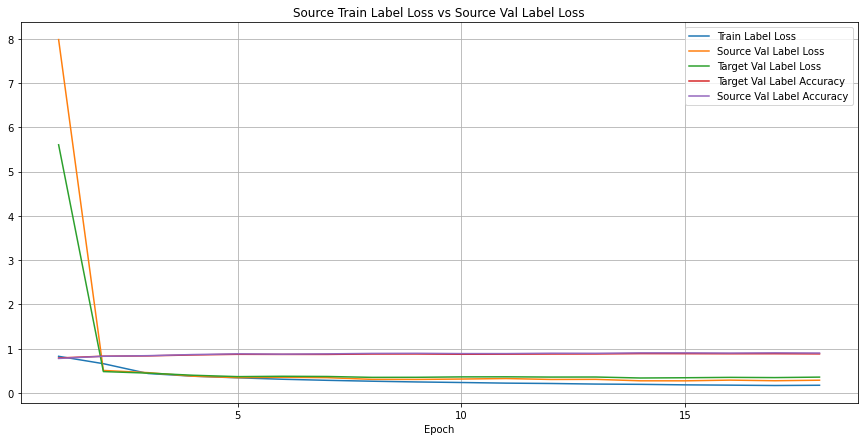

In [25]:
ax = get_loss_curve(experiment)
plt.show()

<AxesSubplot:title={'center':'Results'}>

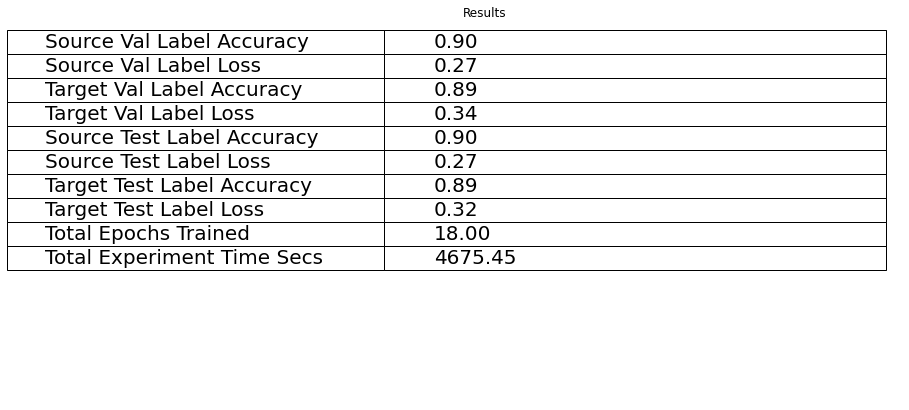

In [26]:
get_results_table(experiment)

<AxesSubplot:title={'center':'Per Domain Validation Accuracy'}, xlabel='domain'>

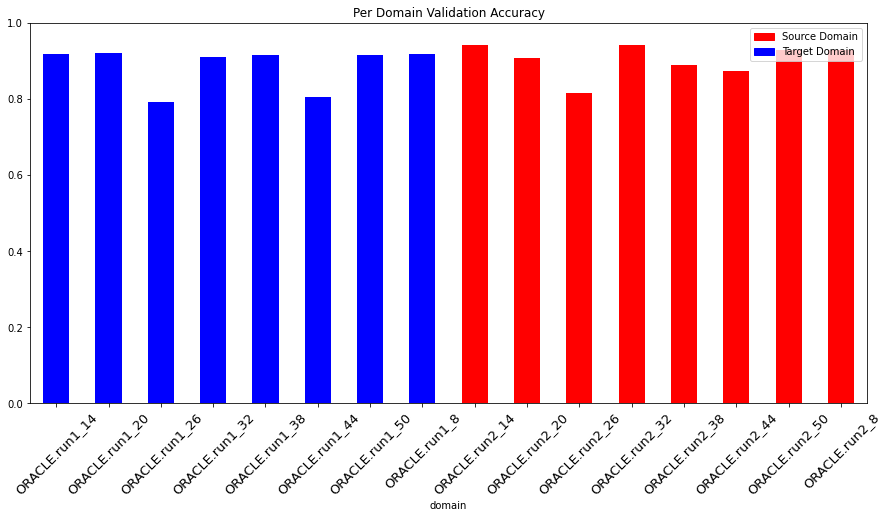

In [27]:
get_domain_accuracies(experiment)

In [28]:
print("Source Test Label Accuracy:", experiment["results"]["source_test_label_accuracy"], "Target Test Label Accuracy:", experiment["results"]["target_test_label_accuracy"])
print("Source Val Label Accuracy:", experiment["results"]["source_val_label_accuracy"], "Target Val Label Accuracy:", experiment["results"]["target_val_label_accuracy"])

Source Test Label Accuracy: 0.9036458333333334 Target Test Label Accuracy: 0.8903645833333333
Source Val Label Accuracy: 0.9033203125 Target Val Label Accuracy: 0.88642578125


In [29]:
json.dumps(experiment)

'{"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "parameters": {"experiment_name": "tl_1v2:oracle.run1.framed-oracle.run2.framed", "device": "cuda", "lr": 0.0001, "n_shot": 3, "n_query": 2, "train_k_factor": 3, "val_k_factor": 2, "test_k_factor": 2, "torch_default_dtype": "torch.float32", "n_epoch": 50, "patience": 3, "criteria_for_best": "target_accuracy", "x_net": [{"class": "nnReshape", "kargs": {"shape": [-1, 1, 2, 256]}}, {"class": "Conv2d", "kargs": {"in_channels": 1, "out_channels": 256, "kernel_size": [1, 7], "bias": false, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 256}}, {"class": "Conv2d", "kargs": {"in_channels": 256, "out_channels": 80, "kernel_size": [2, 7], "bias": true, "padding": [0, 3]}}, {"class": "ReLU", "kargs": {"inplace": true}}, {"class": "BatchNorm2d", "kargs": {"num_features": 80}}, {"class": "Flatten", "kargs": {}}, {"class": "Linear", "kargs": {"in_features": 2048